In [1]:
from pathlib import Path
import networkx as nx
from src import thinning as th
from src import extract_branches_functions as eb
from src import Measure as M
import scipy.sparse
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import imageio.v2 as imageio
from skimage import io
import seaborn as sns
import csv
import pickle
import re
import ast
import nd2
import cv2
import pygeoops
from scipy.spatial import cKDTree
from shapely.geometry import Polygon
from skimage.morphology import remove_small_objects, closing, square
from shapely.geometry import LineString, MultiLineString
%load_ext autoreload
%autoreload 2

In [2]:
# Load ND2 file
with nd2.ND2File(r"E:\Jurr\notebooks\FISH\Fish_in_chips\ND2_files\250716_G67D_cut\G67D_C2_kMyr0.5mM_SSUQ670_DAPI008.nd2") as f:
    print("Dimensions:", f.sizes)
    data = f.asarray()
    print(data.shape)
   
#first channel
z_stack = data[:, 0, :, :] 

# Max projection along z
max_proj = np.max(z_stack, axis=0)  # shape (y, x)

print("Projection shape:", max_proj.shape)

Dimensions: {'Z': 29, 'C': 2, 'Y': 2048, 'X': 2048}
(29, 2, 2048, 2048)
Projection shape: (2048, 2048)


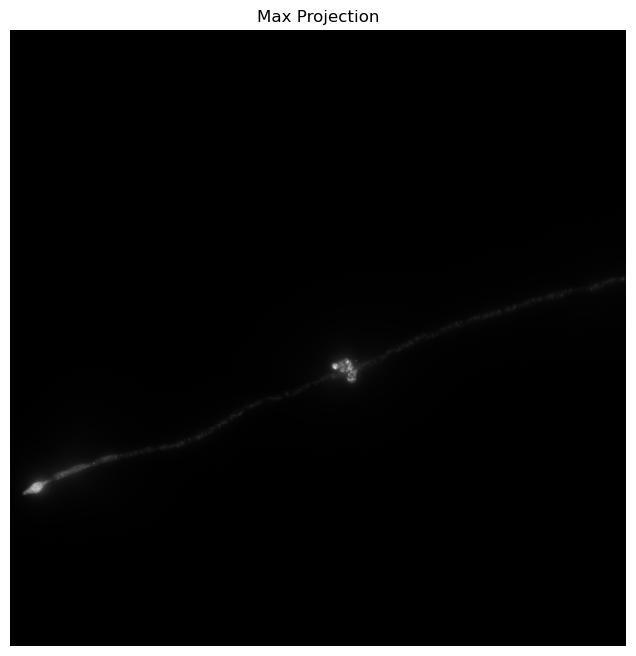

In [3]:
plt.figure(figsize=(8,8)) 
plt.imshow(max_proj, cmap="gray")
plt.title("Max Projection")
plt.axis("off")
plt.gca().invert_xaxis()
plt.show()

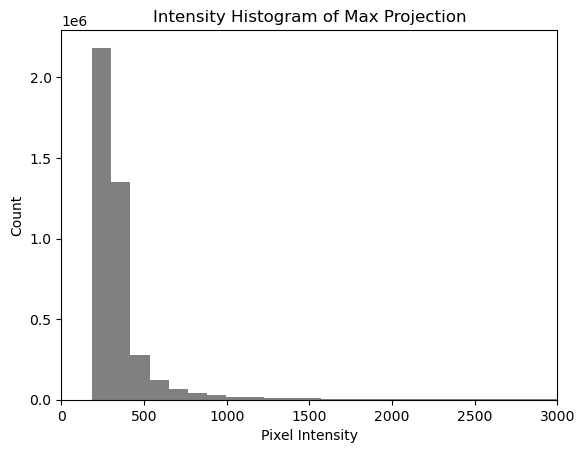

In [4]:
plt.hist(max_proj.ravel(), bins=256, color="gray")
plt.title("Intensity Histogram of Max Projection")
plt.xlabel("Pixel Intensity")
plt.ylabel("Count")
plt.xlim(0, 3000)
plt.show()

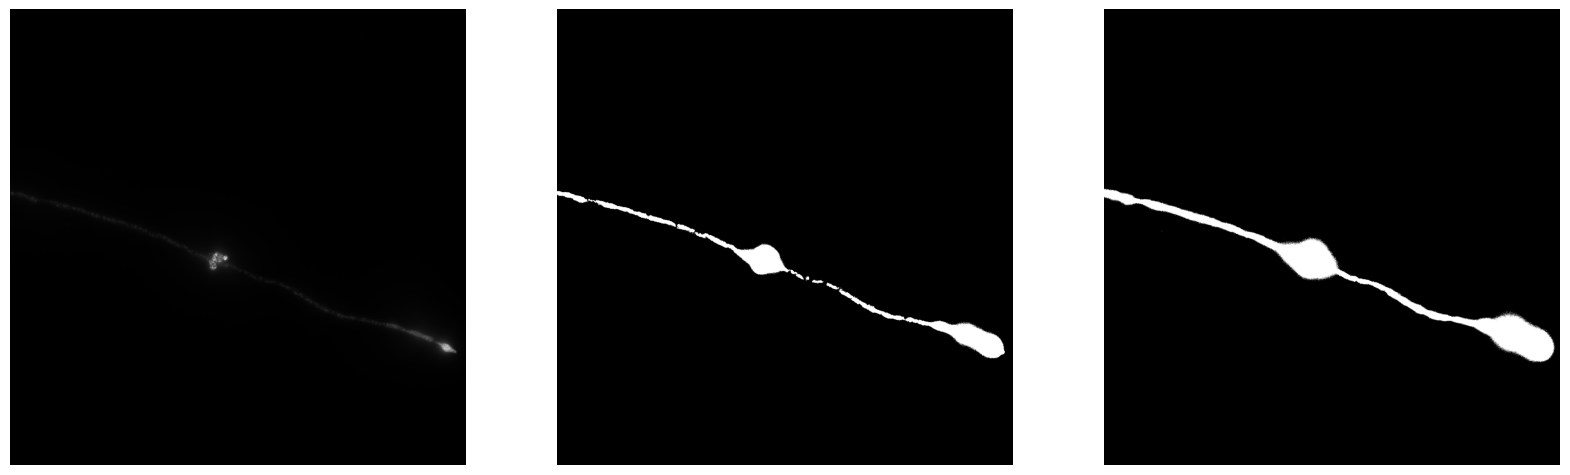

In [5]:
# Create mask, fiddle with the threshold till right
mask = max_proj > 1000
mask_stringent = max_proj > 1500

fig, axes = plt.subplots(1, 3, figsize=(20, 20))

axes[0].imshow(max_proj, cmap='grey')
axes[0].axis('off')

axes[1].imshow(mask_stringent, cmap='grey')
axes[1].axis('off')

axes[2].imshow(mask, cmap='grey')
axes[2].axis('off')




plt.show()

C:\Users\stanl\AppData\Local\Temp\ipykernel_11028\1259494645.py:8: FutureWarning: `square` is deprecated since version 0.25 and will be removed in version 0.27. Use `skimage.morphology.footprint_rectangle` instead.
  mask_clean = closing(mask_clean, square(2))


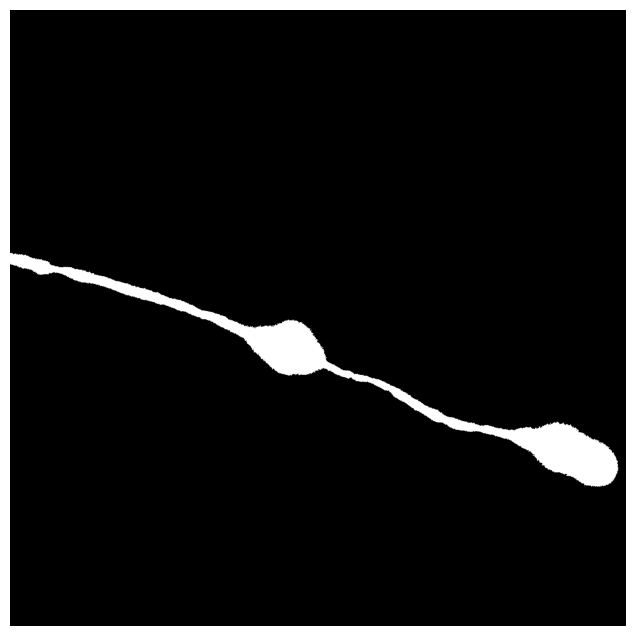

In [6]:
#Clean the mask, very important because polygon conversion wants 1 smooth blob. Square(2) is minimum,
#increase in square makes it thicker to remove gaps easier if necessary, but is generally worse outcome

# Remove tiny specks
mask_clean = remove_small_objects(mask.astype(bool), min_size=64)

# Close gaps
mask_clean = closing(mask_clean, square(2))

plt.figure(figsize=(8,8))
plt.imshow(mask_clean, cmap="gray")
plt.axis("off")
plt.show()

In [7]:
#Convert mask from binary to 8-bit for polygon acceptance
mask_uint8 = (mask_clean.astype(np.uint8)) * 255

# Assume mask is binary: 0 background, 255 foreground
contours, _ = cv2.findContours(mask_uint8, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Convert the largest contour to a Shapely polygon
largest_contour = max(contours, key=cv2.contourArea)
polygon = Polygon(largest_contour.squeeze())

#Create centerline, fiddle with min_branch_length for pruning
centerline = pygeoops.centerline(polygon,min_branch_length=200)

In [8]:
print(centerline)

MULTILINESTRING ((103.0560538116592 854.719730941704, 316.2894736842105 903.1315789473684, 672.2647058823529 1019.2058823529412, 1104.2261904761904 1207.547619047619, 1262.8584905660377 1256.4245283018868, 1424.2478510028652 1353.8868194842407, 1816.0934579439252 1449.1985981308412, 1964.9925373134329 1529.8049040511728), (3.5 814.5, 4 812.5))


In [9]:
#Increase number of coords on centerline, nearest neighbour later connects pixel to coord on centerline ->
# increase number of coors = better resolution / less gaps. #Distance in function is pixels between coords

def densify_line(line, distance):
    """Add points along a LineString every 'distance' units."""
    coords = []
    for i in range(len(line.coords) - 1):
        start = line.coords[i]
        end = line.coords[i + 1]
        segment = LineString([start, end])
        num_points = max(int(segment.length / distance), 1)
        for j in range(num_points):
            coords.append(segment.interpolate(j / num_points, normalized=True).coords[0])
    coords.append(line.coords[-1])
    return LineString(coords)

# Corrected densification for MultiLineString
if centerline.geom_type == "MultiLineString":
    dense_centerline = MultiLineString([densify_line(ls, distance=2) for ls in centerline.geoms])
else:
    dense_centerline = densify_line(centerline, distance=2)

#print(dense_centerline)

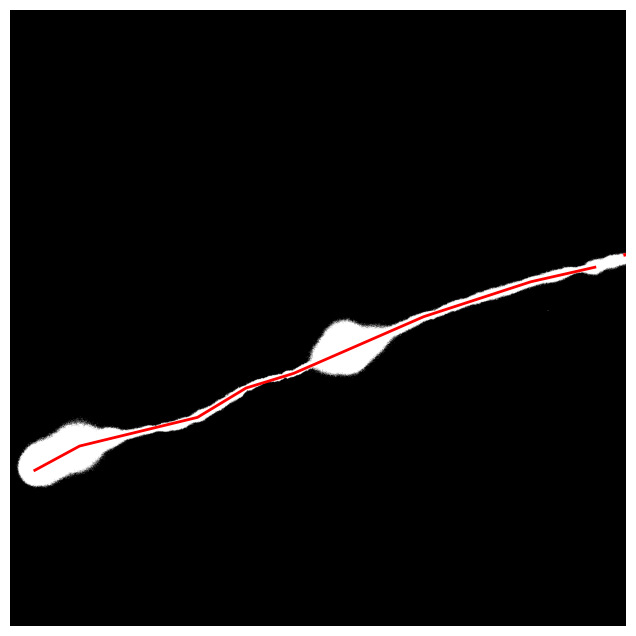

In [10]:
plt.figure(figsize=(8,8))
plt.imshow(mask, cmap='gray')

# If centerline is a MultiLineString (little extra dots)
for line in centerline.geoms:  # iterate over each LineString
    x, y = zip(*line.coords)
    plt.plot(x, y, color='red', linewidth=2)
plt.axis("off")
plt.gca().invert_xaxis()
plt.savefig("Binary_mask_centerline", dpi=300, bbox_inches="tight", pad_inches=0)
plt.show()

In [11]:
#To get the coord of the tip we create a graph with edges and nodes -> single out nodes with only 1 neighbouring node
G = nx.Graph()

# Flatten MultiLineString into edges
if dense_centerline.geom_type == 'MultiLineString':
    lines = dense_centerline.geoms
elif dense_centerline.geom_type == 'LineString':
    lines = [centerline]

for line in lines:
    coords = list(line.coords)
    for i in range(len(coords)-1):
        G.add_edge(coords[i], coords[i+1])


In [12]:
# Get tips based on node neighbors
tips = [node for node, degree in G.degree() if degree == 1]
print("Tip coordinates:", tips)

Tip coordinates: [(103.0560538116592, 854.719730941704), (1964.9925373134329, 1529.8049040511728), (3.5, 814.5), (4.0, 812.5)]


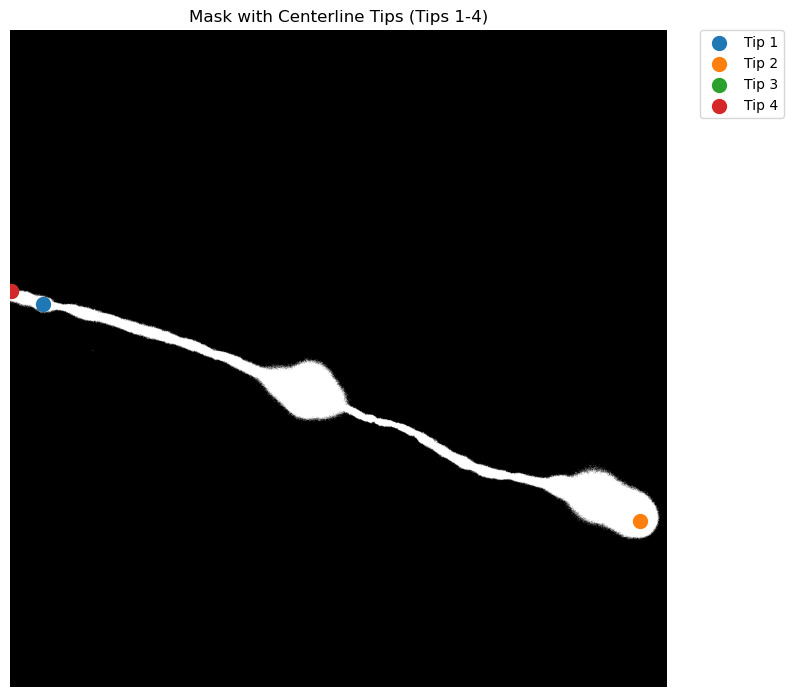

In [13]:
# Image tips on mask and manually select which tip is correct
tips_per_image = 10
num_tips = len(tips)
num_images = int(np.ceil(num_tips / tips_per_image))

for img_idx in range(num_images):
    plt.figure(figsize=(8, 8))
    plt.imshow(mask, cmap='gray')
    
    # Determine the range of tips for this image
    start_idx = img_idx * tips_per_image
    end_idx = min((img_idx + 1) * tips_per_image, num_tips)
    
    cmap = plt.get_cmap('tab20')
    
    for i, tip_idx in enumerate(range(start_idx, end_idx)):
        tip = tips[tip_idx]
        x, y = tip
        color = cmap(i / max(tips_per_image-1, 1))  # normalize i to [0,1]
        plt.scatter(x, y, color=color, s=100, marker='o', label=f'Tip {tip_idx + 1}')
    
    # Move legend outside the image
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    plt.title(f"Mask with Centerline Tips (Tips {start_idx + 1}-{end_idx})")
    plt.axis("off")
    plt.tight_layout()
    plt.show()


In [14]:
#Find which tip it is and obviously subtract 1 because of code indexing
tip_coord = tips[1]
tip_coord

(1964.9925373134329, 1529.8049040511728)

In [15]:
resolution = (1/6.1780) #Resolution in metadata obtained from imageJ (folder = images_metadata)

# --- 1. Mask pixels ---
mask_coords = np.column_stack(np.nonzero(mask))  # (row, col)
mask_xy = mask_coords[:, ::-1]                  # convert to (x, y)

# --- 2. Flatten centerline points ---
centerline_points = []
if dense_centerline.geom_type == 'MultiLineString':
    for line in dense_centerline.geoms:
        centerline_points.extend(list(line.coords))
elif dense_centerline.geom_type == 'LineString':
    centerline_points = list(centerline.coords)

centerline_points = np.array(centerline_points)

# --- 3. Compute cumulative distance along the centerline ---
cum_dist = np.zeros(len(centerline_points))
for i in range(1, len(centerline_points)):
    cum_dist[i] = cum_dist[i-1] + np.linalg.norm(centerline_points[i] - centerline_points[i-1])

# --- 4. Find nearest centerline point for each pixel ---
tree = cKDTree(centerline_points)
distances_perp, indices = tree.query(mask_xy)  # perpendicular distance
nearest_points = centerline_points[indices]    # coordinates of nearest centerline points

# --- 5. Find index of tip in the centerline points ---
tip_index = np.argmin(np.linalg.norm(centerline_points - tip_coord, axis=1))

# --- 6. Compute distance along the centerline to tip ---
dist_along_path = np.abs(cum_dist[indices] - cum_dist[tip_index])

# --- 7. Combine perpendicular and along-path distances ---
total_distance = distances_perp + dist_along_path

# --- 8. create distance map ---
distance_map = np.zeros_like(mask, dtype=float)
distance_map[mask > 0] = total_distance

distance_map_uM = distance_map * resolution

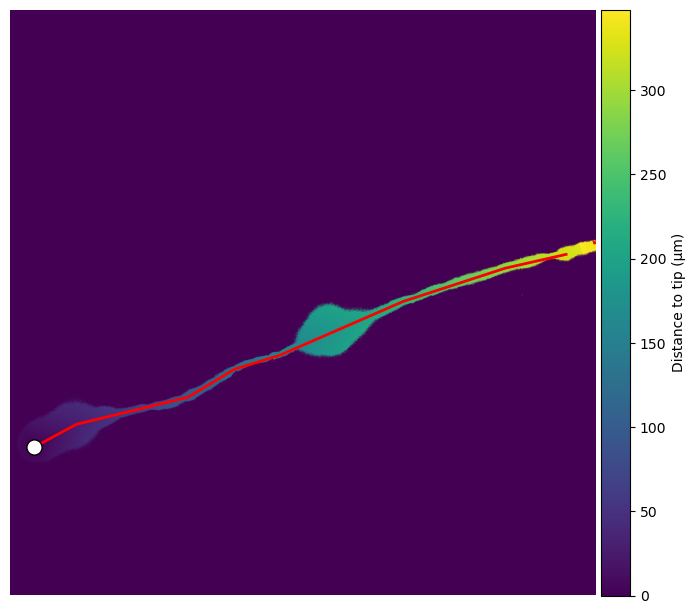

In [16]:
import matplotlib as mpl

plt.figure(figsize=(8, 8))

# 1. Show distance map as heatmap
im = plt.imshow(distance_map_uM, cmap='viridis')  # keep the mappable object
plt.axis('off')

# 2. Overlay centerline in red
if centerline.geom_type == 'MultiLineString':
    for line in centerline.geoms:
        x, y = zip(*line.coords)
        plt.plot(x, y, color='red', linewidth=2)
else:
    x, y = zip(*centerline.coords)
    plt.plot(x, y, color='red', linewidth=2)

# 3. Highlight the tip
plt.scatter(tip_coord[0], tip_coord[1], color='white', edgecolor='black',
            s=120, zorder=5, marker='o', label="Tip")

plt.gca().invert_xaxis()

from mpl_toolkits.axes_grid1 import make_axes_locatable

ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

cbar = plt.colorbar(im, cax=cax)
cbar.set_label("Distance to tip (µm)")

plt.savefig("Distance_map_Ribosome_tip", dpi=300, bbox_inches="tight",pad_inches=0)
plt.show()


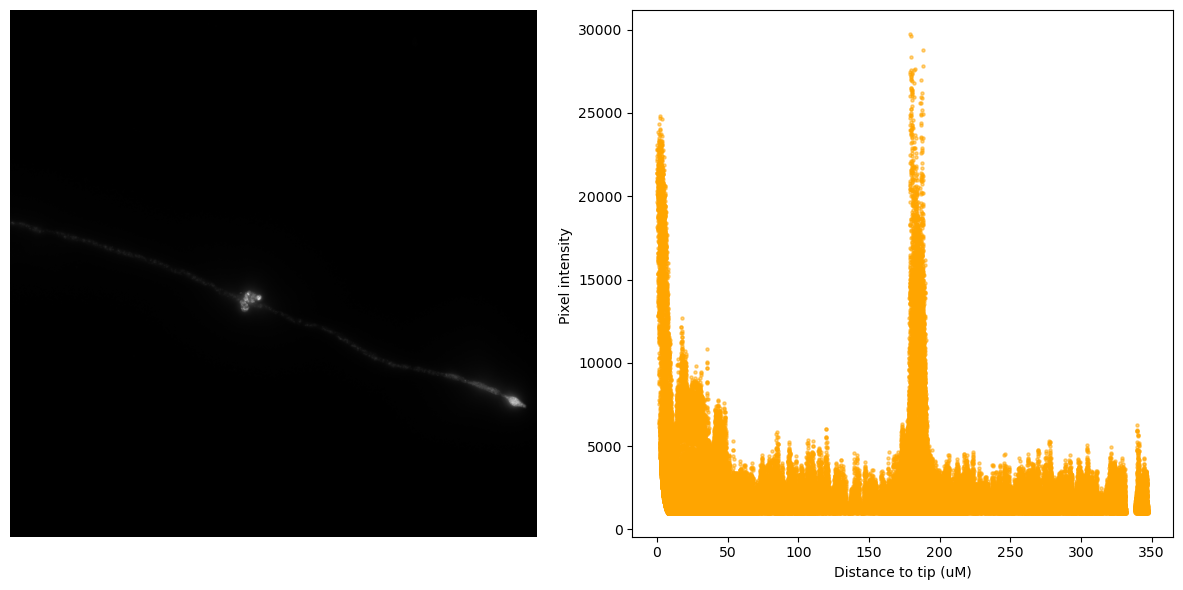

In [17]:
#Max projection next to graph
mask_coords = np.column_stack(np.nonzero(mask))  # (row, col)
mask_y, mask_x = mask_coords[:, 0], mask_coords[:, 1]

# 2. Extract distance and intensity values
distances = distance_map_uM[mask_y, mask_x]       
intensities = max_proj[mask_y, mask_x]

# Create side-by-side figure
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# --- Left: max z-projection ---
axes[0].imshow(max_proj, cmap='gray')
axes[0].axis('off')

# --- Right: intensity vs distance ---
axes[1].scatter(distances, intensities, s=5, alpha=0.5, color='orange')
axes[1].set_xlabel("Distance to tip (uM)")
axes[1].set_ylabel("Pixel intensity ")

plt.tight_layout()
plt.show()

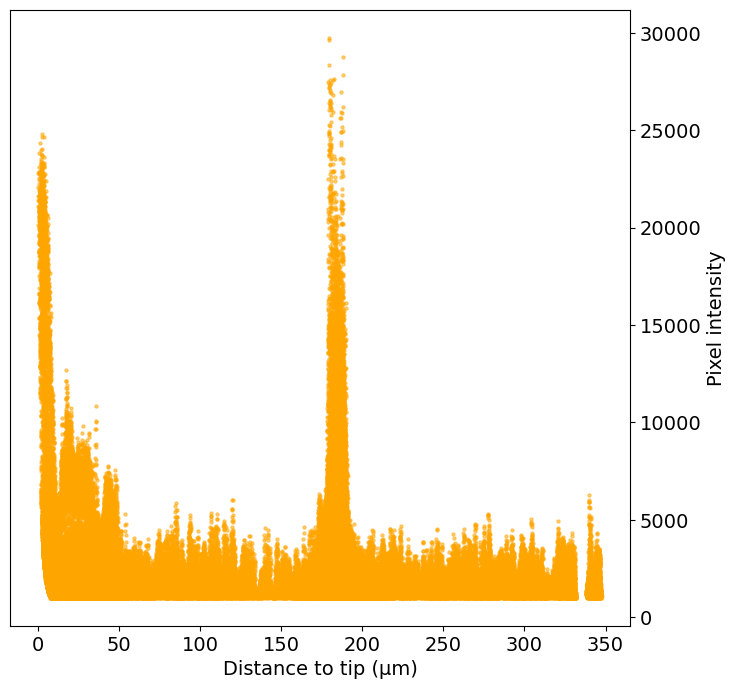

In [18]:
#Create graph and save
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(distances, intensities, s=5, alpha=0.5, color='orange')
ax.set_xlabel("Distance to tip (µm)", fontsize=14)
ax.set_ylabel("Pixel intensity", fontsize=14)

# Move y-axis to the right
ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")
ax.tick_params(axis='both', which='major', labelsize=14)


plt.savefig("RibosomeIntensity_tip.png", dpi=300, bbox_inches="tight")
plt.show()


# Nuclei localization

In [19]:
# Load ND2 file
with nd2.ND2File(r"E:\Jurr\notebooks\FISH\Fish_in_chips\ND2_files\250716_G67D_cut\G67D_C2_kMyr0.5mM_SSUQ670_DAPI008.nd2") as f:
    print("Dimensions:", f.sizes)
    data = f.asarray()  # shape (t, c, z, y, x)
    print(data.shape)
   
#first channel
z_stack_dapi = data[:, 1, :, :]  # shape (z, y, x)

# Max projection along z
max_proj_dapi = np.max(z_stack_dapi, axis=0)  # shape (y, x)

print("Projection shape:", max_proj.shape)

Dimensions: {'Z': 29, 'C': 2, 'Y': 2048, 'X': 2048}
(29, 2, 2048, 2048)
Projection shape: (2048, 2048)


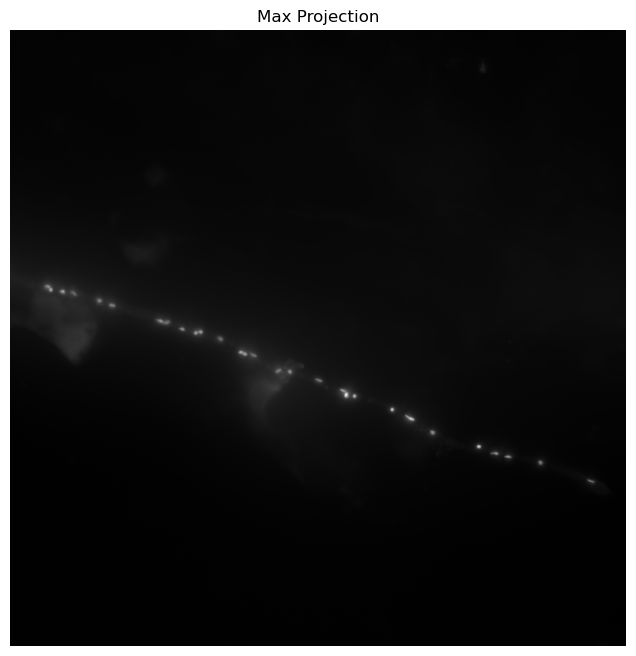

In [20]:
plt.figure(figsize=(8,8)) 
plt.imshow(max_proj_dapi, cmap="gray")
plt.title("Max Projection")
plt.axis("off")
plt.show()

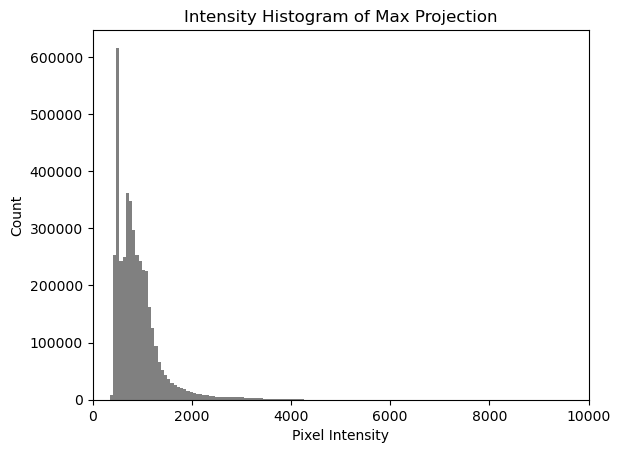

In [21]:
#Overview of intensity for thresholding
plt.hist(max_proj_dapi.ravel(), bins=256, color="gray")
plt.title("Intensity Histogram of Max Projection")
plt.xlabel("Pixel Intensity")
plt.ylabel("Count")
plt.xlim(0, 10000)
plt.show()

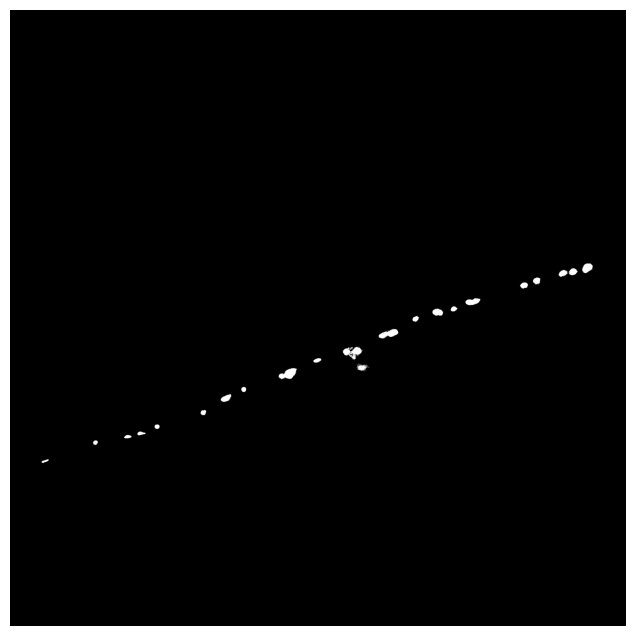

In [22]:
# Create mask, fiddle with the threshold till right
mask_dapi = max_proj_dapi > 4000
plt.figure(figsize=(8,8))
plt.imshow(mask_dapi, cmap="gray")
plt.gca().invert_xaxis()
plt.axis("off")
plt.savefig("Nuclei_binary_mask",dpi = 300, bbox_inches="tight")
plt.show()

In [24]:
from scipy import ndimage
from scipy.ndimage import gaussian_filter
from skimage.feature import peak_local_max
from scipy.spatial import cKDTree
import numpy as np

# --- 1. Distance transform of nuclei mask ---
distance_nuc_bg = ndimage.distance_transform_edt(mask_dapi)

# --- 2. Get seed points (local maxima from the background) ---
min_dis = 30
local_maxi = peak_local_max(
    distance_nuc_bg,
    footprint=np.ones((3, 3)),
    labels=mask_dapi,
    threshold_rel=0.05,
    min_distance=min_dis
)

# --- 3. Convert maxima coords to (x, y) for KDTree ---
local_maxi_xy = local_maxi[:, ::-1]   # peak_local_max gives (row, col) = (y, x)

# --- 4. Nearest centerline point for each local maximum ---
tree = cKDTree(centerline_points)
distances_perp_dapipoint, indices_dapipoint = tree.query(local_maxi_xy)
nearest_points_dapipoint = centerline_points[indices_dapipoint]

# --- 5. Find index of tip in the centerline points ---
tip_index = np.argmin(np.linalg.norm(centerline_points - tip_coord, axis=1))

# --- 6. Compute distance along the centerline to tip ---
dist_along_path_dapipoint = np.abs(cum_dist[indices_dapipoint] - cum_dist[tip_index])

# --- 7. Combine perpendicular and along-path distances ---
total_distance_dapipoint = distances_perp_dapipoint + dist_along_path_dapipoint

# --- 8. Store results back into an image map ---
local_maxi_yx = local_maxi  # keep as (row, col) for indexing into the image
distance_map_dapipoint = np.zeros_like(mask_dapi, dtype=float)
distance_map_dapipoint[tuple(local_maxi_yx.T)] = total_distance_dapipoint

# --- 9. Convert to microns (pixel size from metadata) ---
distance_map_uM_dapipoint = distance_map_dapipoint * (1 / 6.1780)

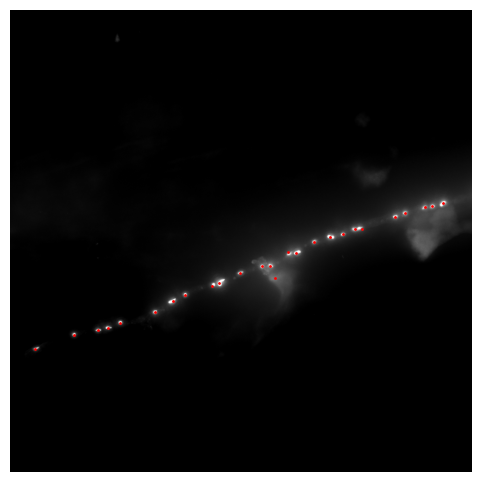

In [25]:
# --- 1. Extract coordinates of detected local maxima ---
mask_y_dapipoint, mask_x_dapipoint = local_maxi_yx[:, 0], local_maxi_yx[:, 1]

# --- 2. Extract distance and intensity values ---
distances_dapipoint = distance_map_uM_dapipoint[mask_y_dapipoint, mask_x_dapipoint]  # distance to tip (µm)
intensities_dapipoint = max_proj_dapi[mask_y_dapipoint, mask_x_dapipoint]            # intensity values


fig, ax = plt.subplots( figsize=(6, 6))

ax.imshow(max_proj_dapi, cmap='gray', vmin = 1000, vmax = 8000)
ax.scatter(mask_x_dapipoint, mask_y_dapipoint, s=1, c='red', marker='o')  # overlay maxima for verification
ax.axis('off')

plt.gca().invert_xaxis()

plt.savefig("Nuclei_distance_centers",dpi = 300, bbox_inches="tight",pad_inches=0)
plt.show()


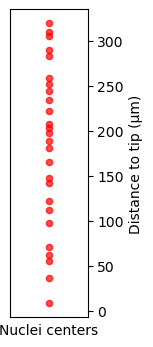

In [26]:
fig, ax = plt.subplots(figsize=(1, 4))

ax.scatter(np.zeros_like(distances_dapipoint), distances_dapipoint,
           s=20, alpha=0.7, color="red")

ax.set_ylabel("Distance to tip (µm)")
ax.set_xlabel("Nuclei centers")
ax.set_xticks([])

# Move y-axis to the right
ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")

plt.savefig("Nuclei_distance_scatter",dpi = 300, bbox_inches="tight")
plt.show()

## Distance map for visualization thesis

In [28]:
# --- 1. Mask pixels ---
mask_coords_dapi = np.column_stack(np.nonzero(mask_dapi))  # (row, col)
mask_xy_dapi = mask_coords_dapi[:, ::-1]                  # convert to (x, y)

# --- 4. Find nearest centerline point for each pixel ---
tree = cKDTree(centerline_points)
distances_perp_dapi, indices_dapi = tree.query(mask_xy_dapi)  # perpendicular distance
nearest_points_dapi = centerline_points[indices_dapi]    # coordinates of nearest centerline points

# --- 5. Find index of tip 2 in the centerline points ---
tip_index = np.argmin(np.linalg.norm(centerline_points - tip_coord, axis=1))

# --- 6. Compute distance along the centerline to tip 2 ---
dist_along_path_dapi = np.abs(cum_dist[indices_dapi] - cum_dist[tip_index])

# --- 7. Combine perpendicular and along-path distances ---
total_distance_dapi = distances_perp_dapi + dist_along_path_dapi

# --- 8. Optional: create distance map ---
distance_map_dapi = np.zeros_like(mask_dapi, dtype=float)
distance_map_dapi[mask_dapi > 0] = total_distance_dapi

distance_map_uM_dapi = distance_map_dapi * (1/6.1780) #Resolution in metadata obtained from imageJ (folder = images_metadata)

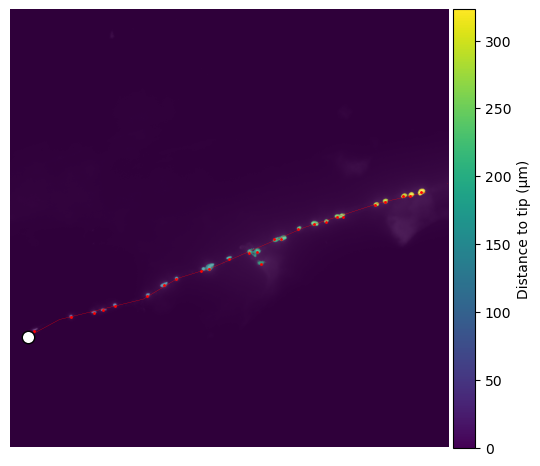

In [30]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

plt.figure(figsize=(6, 6))

# 1. Show distance map as background heatmap
im = plt.imshow(distance_map_uM_dapi, cmap='viridis')  # <-- background is distance map
plt.axis('off')

# 2. Overlay DAPI image as transparent grayscale (optional blending)
plt.imshow(max_proj_dapi, cmap='gray', vmin=1000, vmax=8000, alpha=0.3)

# 3. Overlay DAPI maxima points
plt.scatter(mask_x_dapipoint, mask_y_dapipoint, s=1, c='red', marker='o')

# 4. Overlay centerline in red
if centerline.geom_type == 'MultiLineString':
    for line in centerline.geoms:
        x, y = zip(*line.coords)
        plt.plot(x, y, color='red', linewidth=0.2)
else:
    x, y = zip(*centerline.coords)
    plt.plot(x, y, color='red', linewidth=0.2)

plt.scatter(tip_coord[0], tip_coord[1], color='white', edgecolor='black',
            s=80, zorder=5, marker='o')

plt.gca().invert_xaxis()

ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

cbar = plt.colorbar(im, cax=cax)
cbar.set_label("Distance to tip (µm)")
plt.savefig("Nuclei_center_distance_map",dpi = 300, bbox_inches="tight",pad_inches=0)
plt.show()